In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'aizarani', 'halpern', 'richter']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
# DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Aizarani 2019'}
DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Halpern Shenhav 2017'}
DIC_INFO['richter'] = {'species': 'mmusculus', 'dname': 'Richter Deligiannis 2020'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.hm': DATA_PATH+'/score_file/score.tms_facs_with_cov.hep_metabolic',
#                   'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.gwas_max_abs_z.top500',
                  'aizarani': DATA_PATH+'/score_file/score.liver_atlas.magma_10kb_1000',
                  'aizarani.hm': DATA_PATH+'/score_file/score.liver_atlas_with_cov.hep_metabolic',
                  'halpern': DATA_PATH+'/score_file/score.mouse_liver_halpern.magma_10kb_1000',
                  'halpern.hm': DATA_PATH+'/score_file/score.mouse_liver_halpern_with_cov.hep_metabolic',  
                  'richter': DATA_PATH+'/score_file/score.richter_with_cov.magma_10kb_1000',
                  'richter.hm': DATA_PATH+'/score_file/score.richter_with_cov.hep_metabolic',  
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['UKB_460K.biochemistry_AlanineAminotransferase',
                          'UKB_460K.biochemistry_AlkalinePhosphatase',
                          'UKB_460K.biochemistry_Cholesterol',
                          'UKB_460K.biochemistry_HDLcholesterol',
                          'UKB_460K.biochemistry_LDLdirect',
                          'UKB_460K.biochemistry_SHBG',
                          'UKB_460K.biochemistry_Testosterone_Male',
                          'UKB_460K.biochemistry_TotalBilirubin',
                          'UKB_460K.biochemistry_Triglycerides']
DIC_TRAIT_LIST['facs.hm'] = ['CV', 'PN', 
                             'Beta-oxidation', 'Cholesterol biosynthesis', 'Glycolysis', 'Protein secretion',
                             'Bile acid production', 'Gluconeogenesis', 'Lipogenesis', 'Xenobiotic metabolism']
DIC_TRAIT_LIST['aizarani'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['aizarani.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['halpern'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['halpern.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['richter'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['richter.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()

# Set trait info
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short

### Load data 

In [10]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')
dic_data_raw['richter'] = dl.load_richter_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'hep.facs_annot.h5ad')
# dic_data_proc['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']
# dic_data_proc['aizarani'] = dl.load_aizarani_raw_data(opt='processed')
dic_data_proc['aizarani'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                      'tms_proc/hep.aizarani.h5ad')
dic_data_proc['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')
dic_data_proc['richter'] = dl.read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                        'tms_proc/hep.richter.h5ad')

# Add mt_prop to facs data and filter out high mt cells 
temp_adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/'
                       'adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['mt_prop'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df['mt_prop'])
dic_data_proc['facs'].obs['mt_prop'] = df_mt['mt_prop'].values
dic_data_proc['facs'] = dic_data_proc['facs'][dic_data_proc['facs'].obs['mt_prop']<0.3,:].copy()

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [11]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.mouse_liver_halpern_with_cov.hep_metabolic/Lipogenesis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.richter_with_cov.hep_metabolic/Lipogenesis.score.gz


In [5]:
# # Compute correlation between n_gene and score 
# dic_data_raw['aizarani'].obs['n_genes'] = (dic_data_raw['aizarani'].X>0).sum(axis=1)
# df_plot = dic_data_raw['aizarani'].obs[['n_genes']]
# df_plot = df_plot.join(dic_score['aizarani'])
# df_plot = df_plot.loc[df_plot.isna().sum(axis=1)==0]
# for trait in DIC_TRAIT_LIST['aizarani']:
#     print('# %-30s    corr=%0.3f'%(trait, np.corrcoef(df_plot['n_genes'], df_plot['%s.norm_score'%trait])[0,1]))

<AxesSubplot:xlabel='Ploidy', ylabel='UKB_460K.biochemistry_LDLdirect.norm_score'>

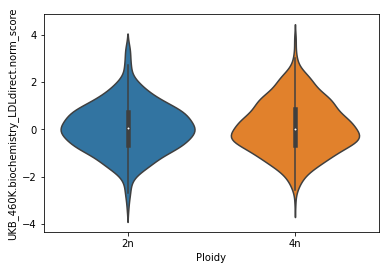

In [13]:
trait = 'UKB_460K.biochemistry_LDLdirect'
df_plot = dic_data_proc['richter'].obs.copy()
df_plot = df_plot.join(dic_score['richter'][['%s.norm_score'%trait]])
sns.violinplot(data=df_plot, x='Ploidy', y='%s.norm_score'%trait)

In [14]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani', 'halpern', 'richter']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
            continue
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs UKB_460K.biochemistry_AlanineAminotransferase
# Loading facs UKB_460K.biochemistry_AlkalinePhosphatase
# Loading facs UKB_460K.biochemistry_Cholesterol
# Loading facs UKB_460K.biochemistry_HDLcholesterol
# Loading facs UKB_460K.biochemistry_LDLdirect
# Loading facs UKB_460K.biochemistry_SHBG
# Loading facs UKB_460K.biochemistry_Testosterone_Male
# Loading facs UKB_460K.biochemistry_TotalBilirubin
# Loading facs UKB_460K.biochemistry_Triglycerides
# Loading facs.hm CV
# Loading facs.hm PN
# Loading facs.hm Beta-oxidation
# Loading facs.hm Cholesterol biosynthesis
# Loading facs.hm Glycolysis
# Loading facs.hm Protein secretion
# Loading facs.hm Bile acid production
# Loading facs.hm Gluconeogenesis
# Loading facs.hm Lipogenesis
# Loading facs.hm Xenobiotic metabolism
# Loading aizarani UKB_460K.biochemistry_AlanineAminotransferase
# Loading aizarani UKB_460K.biochemistry_AlkalinePhosphatase
# Loading aizarani UKB_460K.biochemistry_Cholesterol
# Loading aizarani UKB_460K.b

### Check CV/PN score 

In [16]:
ds = 'facs'
df_plot = dic_data_proc[ds].obs.loc[dic_data_proc[ds].obs['leiden'].isin(['4', '5']), ['n_genes']]
df_plot = df_plot.join(dic_score['%s.hm'%ds][['CV.norm_score', 'PN.norm_score']])
display(df_plot.corr())

ds = 'aizarani'
df_plot = dic_data_proc[ds].obs[['zonation']]
df_plot = df_plot.join(dic_score['%s.hm'%ds][['CV.norm_score', 'PN.norm_score']])
display(df_plot.corr())

ds = 'halpern'
df_plot = dic_data_proc[ds].obs[['Layer 1', 'Layer 9']]
df_plot = df_plot.join(dic_score['%s.hm'%ds][['CV.norm_score', 'PN.norm_score']])
display(df_plot.corr())

ds = 'richter'
df_plot = dic_data_proc[ds].obs[['n_genes']]
df_plot = df_plot.join(dic_score['%s.hm'%ds][['CV.norm_score', 'PN.norm_score']])
display(df_plot.corr())

,n_genes,CV.norm_score,PN.norm_score
n_genes,1.000000,0.281274,-0.166792
CV.norm_score,0.281274,1.000000,-0.613608
PN.norm_score,-0.166792,-0.613608,1.000000


,zonation,CV.norm_score,PN.norm_score
zonation,1.000000,-0.129716,0.115041
CV.norm_score,-0.129716,1.000000,0.519022
PN.norm_score,0.115041,0.519022,1.000000


,Layer 1,Layer 9,CV.norm_score,PN.norm_score
Layer 1,1.000000,-0.110522,0.426409,-0.358539
Layer 9,-0.110522,1.000000,-0.420860,0.449834
CV.norm_score,0.426409,-0.420860,1.000000,-0.938344
PN.norm_score,-0.358539,0.449834,-0.938344,1.000000


,n_genes,CV.norm_score,PN.norm_score
n_genes,1.000000,0.087800,-0.121401
CV.norm_score,0.087800,1.000000,-0.085074
PN.norm_score,-0.121401,-0.085074,1.000000


### UMAP for all hepatocytes

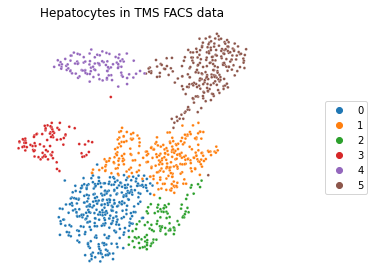

In [5]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['leiden'])

plt.figure(figsize=[5.5,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Hepatocytes in TMS FACS data')
plt.tight_layout()
plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

richter UKB_460K.biochemistry_AlanineAminotransferase
richter UKB_460K.biochemistry_AlkalinePhosphatase


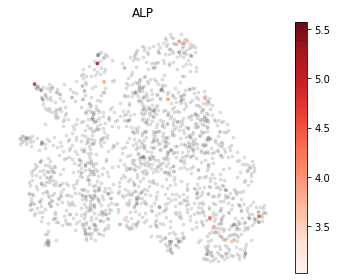

richter UKB_460K.biochemistry_Cholesterol
richter UKB_460K.biochemistry_HDLcholesterol
richter UKB_460K.biochemistry_LDLdirect
richter UKB_460K.biochemistry_SHBG
richter UKB_460K.biochemistry_Testosterone_Male
richter UKB_460K.biochemistry_TotalBilirubin


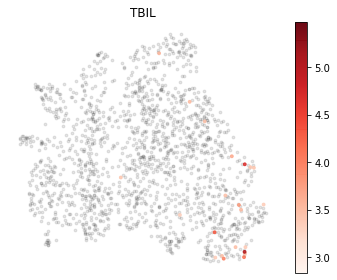

richter UKB_460K.biochemistry_Triglycerides


In [59]:
ds = 'facs'
for trait in DIC_TRAIT_LIST['facs']:
#     for ds in DS_LIST:
    for ds in ['richter']:
        print(ds, trait)
        df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                               data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                     'leiden_anno':dic_data_proc[ds].obs['leiden']})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
        df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

        ind_select = df_plot['%s.fdr'%trait]<0.1
        if ind_select.sum()<10:
            continue
        
        plt.figure(figsize=[5,4])
        ax = plt.subplot(1,1,1)
        ax.axis('off')
        vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
        vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
        plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                    c='k', s=8, alpha=0.1)
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                    c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                    cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
        plt.colorbar()
        plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

        plt.tight_layout()
    #     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
        plt.show()
    #     break

### Annotation for LDL associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical


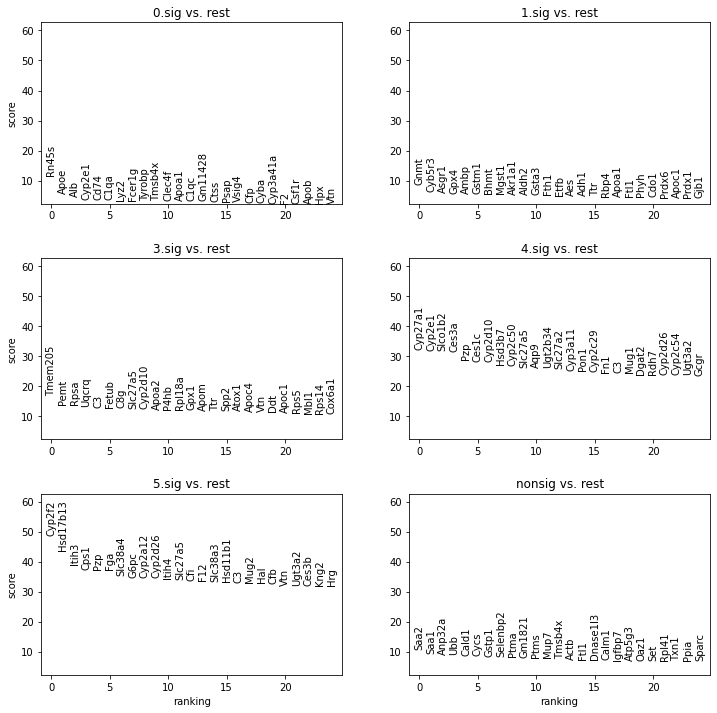

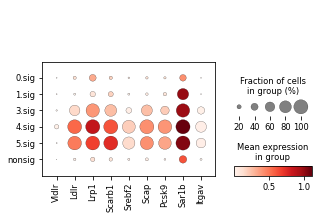

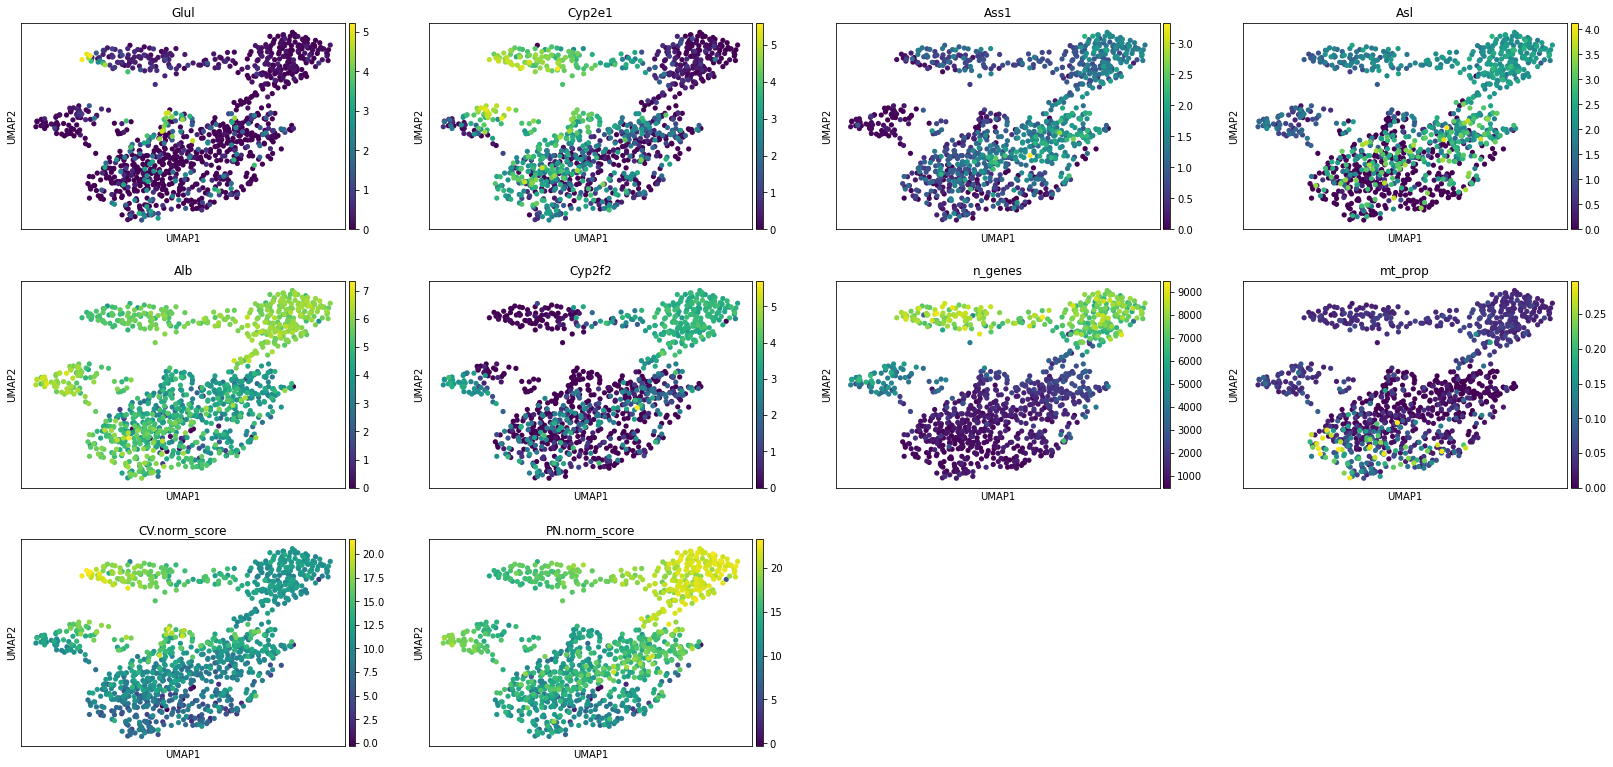

In [20]:
# trait = 'UKB_460K.biochemistry_HDLcholesterol'
trait = 'UKB_460K.biochemistry_LDLdirect'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 


# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2', # Lipoprotein receptor
#                'Alb', # Plasma protein secretion
#                'Fgb', 'F2', 'F9', 'Kng1', 'Aplp2', # Blood clotting factors 
#                'Gc', # Vitamin D
#                'G6pc', # Glycogenolysis and gluconeogenesis
#                'Cyp', 'Glul', 'Oat', 'Ces3a', 'Slc22a1', 'Aldh3a2', # Detoxification
#                'Akr1c6', 'Abcb4', # Bile acid synthesis
#                'Blvrb', # Heme synthesis
#                'Csad', # Amino acid metabolism
#                'Rgn', # Calcium homeostasis
#                'Hmgcl', # Ketogenesis
#                'Stard10', 'Apoa', 'Apoc', # Hormone, vitamin, and lipid transport
#                'Hmgcs2', 'Aldh2', 'Ppara', 'MGll', # Cholesterol, alcohol and lipid metabolism
#                'Agt', 'Igfbp2', 'Igfbp4', # Hormone synthesis and secretion
#                'Hamp', 'Ftl1', 'Hp', # Iron homeostasis and storage
#                'Ass1', 'Asl', # Urea synthesis from ammonia 
#                'Gpx1', # Glutathione synthesis 
#                'Pck1', 'Fbp1', # Gluconeogenesis
#                'Arg1', # Urea synthesis from arginine
#                'Cat', # Catalase production
#                'Cox', 'Nduf' # Respiration (b-oxidation)
#                'Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Cyp2e1', # Central
#                'Arg1', 'Alb', 'Pck1' # Periportal
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2',
               'n_genes', 'mt_prop', 'CV.norm_score', 'PN.norm_score']
adata.obs = adata.obs.join(dic_score['facs.hm'][['CV.norm_score', 'PN.norm_score']])
sc.pl.umap(adata, color=marker_list)

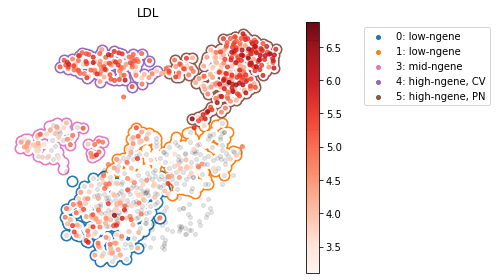

In [21]:
# UMAP plot with annotations 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
ds='facs'
# group_list = ['4.sig', '2.sig', '0.sig', '1.sig', '5.sig']
dic_config = {'0.sig': ['C0', '0: low-ngene'],
              '1.sig': ['C1', '1: low-ngene'],
              '3.sig': ['C6', '3: mid-ngene'], 
              '4.sig': ['C4', '4: high-ngene, CV'], 
              '5.sig': ['C5', '5: high-ngene, PN'], 
              'nonsig': ['k', 'nonsig']
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in group_list:
    ind_select = df_plot['leiden']==cluster.split('.')[0]
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1], zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.5), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar()
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_LDL_umap.svg')
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_LDL_umap.png')
plt.show()

In [56]:
# Associating signal with ploidy using ctrl scores 
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
adata.obs['ploidy'] = adata.obs['leiden'].isin(['4','5'])*2 + adata.obs['leiden'].isin(['3'])
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
ds = 'facs'
score='facs'
cov = 'ploidy'
for trait in DIC_TRAIT_LIST[ds]:
    
    df_reg = adata.obs[['ploidy']].copy()
    df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
    df_reg = df_reg.join(dic_ctrl_score[score][trait])
    corr_ = sp.stats.pearsonr(df_reg[cov].values, df_reg['%s.norm_score'%trait].values)[0]
    
    v_corr_ = np.zeros(500)
    for i in range(500):
        v_corr_[i] = sp.stats.pearsonr(df_reg[cov].values, df_reg['ctrl_norm_score_%d'%i].values)[0]
        
        
    p_ = ((corr_ <= v_corr_).sum()+1) / 501
    df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]

display(df_stats)

,COV,TRAIT,CORR,P
ploidy.UKB_460K.biochemistry_AlanineAminotransferase,ploidy,UKB_460K.biochemistry_AlanineAminotransferase,0.795465,0.001996
ploidy.UKB_460K.biochemistry_AlkalinePhosphatase,ploidy,UKB_460K.biochemistry_AlkalinePhosphatase,0.762292,0.001996
ploidy.UKB_460K.biochemistry_Cholesterol,ploidy,UKB_460K.biochemistry_Cholesterol,0.738253,0.001996
ploidy.UKB_460K.biochemistry_HDLcholesterol,ploidy,UKB_460K.biochemistry_HDLcholesterol,0.655272,0.005988
ploidy.UKB_460K.biochemistry_LDLdirect,ploidy,UKB_460K.biochemistry_LDLdirect,0.677356,0.007984
ploidy.UKB_460K.biochemistry_SHBG,ploidy,UKB_460K.biochemistry_SHBG,0.727007,0.005988
ploidy.UKB_460K.biochemistry_Testosterone_Male,ploidy,UKB_460K.biochemistry_Testosterone_Male,0.694427,0.001996
ploidy.UKB_460K.biochemistry_TotalBilirubin,ploidy,UKB_460K.biochemistry_TotalBilirubin,0.732720,0.001996
ploidy.UKB_460K.biochemistry_Triglycerides,ploidy,UKB_460K.biochemistry_Triglycerides,0.760841,0.001996


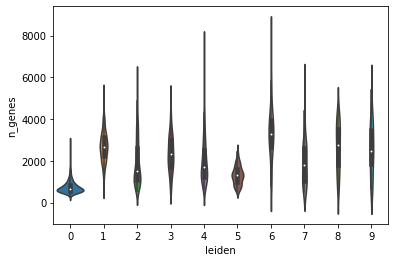

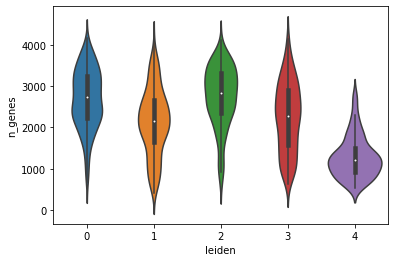

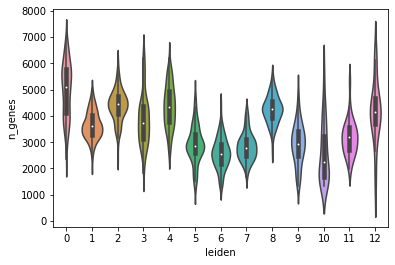

In [94]:
for ds in DS_LIST[1:]: 
    plt.figure()
    sns.violinplot(data=dic_data_proc[ds].obs, x='leiden', y='n_genes')
    plt.show()

In [116]:
# Associating signal with ploidy using ctrl scores 
    
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
ds = 'aizarani'
score='aizarani'
cov = 'ploidy'

for trait in DIC_TRAIT_LIST[ds]:
    
    df_reg = dic_data_proc[ds].obs[['n_genes', 'leiden']].copy()
    df_reg['ploidy'] = (~df_reg['leiden'].isin(['0', '2', '4', '5']))*1
    df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
    df_reg = df_reg.join(dic_ctrl_score[score][trait])
#     df_reg = df_reg.loc[df_reg['%s.norm_score'%trait]<3]
    corr_ = sp.stats.pearsonr(df_reg[cov].values, df_reg['%s.norm_score'%trait].values)[0]
    
    v_corr_ = np.zeros(500)
    for i in range(500):
        v_corr_[i] = sp.stats.pearsonr(df_reg[cov].values, df_reg['ctrl_norm_score_%d'%i].values)[0]
        
    p_ = ((corr_ <= v_corr_).sum()+1) / 501
    df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]

display(df_stats)

,COV,TRAIT,CORR,P
ploidy.UKB_460K.biochemistry_AlanineAminotransferase,ploidy,UKB_460K.biochemistry_AlanineAminotransferase,0.280136,0.007984
ploidy.UKB_460K.biochemistry_AlkalinePhosphatase,ploidy,UKB_460K.biochemistry_AlkalinePhosphatase,0.233608,0.021956
ploidy.UKB_460K.biochemistry_Cholesterol,ploidy,UKB_460K.biochemistry_Cholesterol,0.171394,0.065868
ploidy.UKB_460K.biochemistry_HDLcholesterol,ploidy,UKB_460K.biochemistry_HDLcholesterol,0.032970,0.395210
ploidy.UKB_460K.biochemistry_LDLdirect,ploidy,UKB_460K.biochemistry_LDLdirect,0.234154,0.015968
ploidy.UKB_460K.biochemistry_SHBG,ploidy,UKB_460K.biochemistry_SHBG,0.260232,0.005988
ploidy.UKB_460K.biochemistry_Testosterone_Male,ploidy,UKB_460K.biochemistry_Testosterone_Male,0.229836,0.023952
ploidy.UKB_460K.biochemistry_TotalBilirubin,ploidy,UKB_460K.biochemistry_TotalBilirubin,0.220640,0.021956
ploidy.UKB_460K.biochemistry_Triglycerides,ploidy,UKB_460K.biochemistry_Triglycerides,0.235360,0.011976


In [113]:
# Associating signal with ploidy using ctrl scores 
    
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
ds = 'halpern'
score='halpern'
cov = 'ploidy'

for trait in DIC_TRAIT_LIST[ds]:
    
    df_reg = dic_data_proc[ds].obs[['n_genes', 'leiden']].copy()
    df_reg['ploidy'] = (df_reg['leiden']=='4')*1
    df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
    df_reg = df_reg.join(dic_ctrl_score[score][trait])
#     df_reg = df_reg.loc[df_reg['%s.norm_score'%trait]<3]
    corr_ = sp.stats.pearsonr(df_reg[cov].values, df_reg['%s.norm_score'%trait].values)[0]
    
    v_corr_ = np.zeros(500)
    for i in range(500):
        v_corr_[i] = sp.stats.pearsonr(df_reg[cov].values, df_reg['ctrl_norm_score_%d'%i].values)[0]
        
    p_ = ((corr_ <= v_corr_).sum()+1) / 501
    df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]

display(df_stats)

,COV,TRAIT,CORR,P
ploidy.UKB_460K.biochemistry_AlanineAminotransferase,ploidy,UKB_460K.biochemistry_AlanineAminotransferase,0.080099,0.081836
ploidy.UKB_460K.biochemistry_AlkalinePhosphatase,ploidy,UKB_460K.biochemistry_AlkalinePhosphatase,0.085456,0.081836
ploidy.UKB_460K.biochemistry_Cholesterol,ploidy,UKB_460K.biochemistry_Cholesterol,0.052042,0.205589
ploidy.UKB_460K.biochemistry_HDLcholesterol,ploidy,UKB_460K.biochemistry_HDLcholesterol,0.007097,0.453094
ploidy.UKB_460K.biochemistry_LDLdirect,ploidy,UKB_460K.biochemistry_LDLdirect,0.023024,0.365269
ploidy.UKB_460K.biochemistry_SHBG,ploidy,UKB_460K.biochemistry_SHBG,0.096936,0.059880
ploidy.UKB_460K.biochemistry_Testosterone_Male,ploidy,UKB_460K.biochemistry_Testosterone_Male,0.070962,0.111776
ploidy.UKB_460K.biochemistry_TotalBilirubin,ploidy,UKB_460K.biochemistry_TotalBilirubin,0.067908,0.129741
ploidy.UKB_460K.biochemistry_Triglycerides,ploidy,UKB_460K.biochemistry_Triglycerides,-0.055381,0.788423


In [111]:
# Associating signal with ploidy using ctrl scores 
    
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
ds = 'richter'
score='richter'
cov = 'ploidy'
for trait in DIC_TRAIT_LIST[ds]:
    
    ind_select = ( dic_data_proc['richter'].obs['inferred_cell_label']=='Hepatocytes')
    df_reg = dic_data_proc['richter'].obs.loc[ind_select, ['Ploidy']].copy()
    df_reg['ploidy'] = (df_reg['Ploidy']=='4n')*1
    df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
    df_reg = df_reg.join(dic_ctrl_score[score][trait])
#     df_reg = df_reg.loc[df_reg['%s.norm_score'%trait]<3]
    corr_ = sp.stats.pearsonr(df_reg[cov].values, df_reg['%s.norm_score'%trait].values)[0]
    
    v_corr_ = np.zeros(500)
    for i in range(500):
        v_corr_[i] = sp.stats.pearsonr(df_reg[cov].values, df_reg['ctrl_norm_score_%d'%i].values)[0]
        
    p_ = ((corr_ <= v_corr_).sum()+1) / 501
    df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]

display(df_stats)

,COV,TRAIT,CORR,P
ploidy.UKB_460K.biochemistry_AlanineAminotransferase,ploidy,UKB_460K.biochemistry_AlanineAminotransferase,0.004193,0.469062
ploidy.UKB_460K.biochemistry_AlkalinePhosphatase,ploidy,UKB_460K.biochemistry_AlkalinePhosphatase,0.045296,0.149701
ploidy.UKB_460K.biochemistry_Cholesterol,ploidy,UKB_460K.biochemistry_Cholesterol,0.027737,0.245509
ploidy.UKB_460K.biochemistry_HDLcholesterol,ploidy,UKB_460K.biochemistry_HDLcholesterol,0.015902,0.375250
ploidy.UKB_460K.biochemistry_LDLdirect,ploidy,UKB_460K.biochemistry_LDLdirect,0.016584,0.361277
ploidy.UKB_460K.biochemistry_SHBG,ploidy,UKB_460K.biochemistry_SHBG,0.072714,0.041916
ploidy.UKB_460K.biochemistry_Testosterone_Male,ploidy,UKB_460K.biochemistry_Testosterone_Male,0.039659,0.171657
ploidy.UKB_460K.biochemistry_TotalBilirubin,ploidy,UKB_460K.biochemistry_TotalBilirubin,0.075961,0.047904
ploidy.UKB_460K.biochemistry_Triglycerides,ploidy,UKB_460K.biochemistry_Triglycerides,0.053176,0.113772


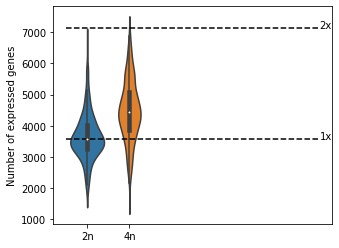

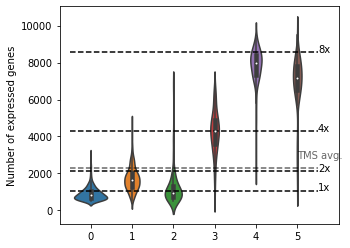

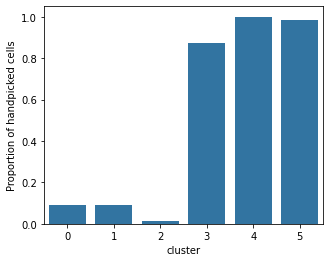

In [48]:
# n_gene 
ds = 'richter'
df_plot = dic_data_proc[ds].obs.loc[dic_data_proc[ds].obs['inferred_cell_label']=='Hepatocytes', 
                                    ['n_genes', 'leiden', 'Ploidy']]
ngene_hep = df_plot.loc[df_plot['Ploidy']=='2n','n_genes'].median()
plt.figure(figsize=[5,4])
sns.violinplot(data=df_plot, x='Ploidy', y='n_genes')
for factor in [1,2]:
    plt.plot([-0.5,5.5], [ngene_hep*factor, ngene_hep*factor], '--', color='k')
    plt.text(5.5, ngene_hep*factor, '%dx'%factor)
plt.xlabel('')
plt.ylabel('Number of expressed genes')
plt.savefig(FIG_PATH+'/ngenes.%s.svg'%ds)
plt.show()


ds = 'facs'
ngene_all = dic_data_raw['facs'].obs['n_genes'].median()
ngene_hep = dic_data_proc['facs'].obs.loc[dic_data_proc['facs'].obs['leiden'].isin(['0','1','2']),'n_genes'].median()

df_plot = dic_data_proc[ds].obs[['n_genes', 'leiden', 'FACS.selection']]
plt.figure(figsize=[5,4])
sns.violinplot(data=df_plot, x='leiden', y='n_genes')
plt.plot([-0.5,5.5], [ngene_all, ngene_all], '--', color='k', alpha=0.6)
plt.text(5, ngene_all+500, 'TMS avg.', alpha=0.6)
for factor in [1,2,4,8]:
    plt.plot([-0.5,5.5], [ngene_hep*factor, ngene_hep*factor], '--', color='k')
    plt.text(5.5, ngene_hep*factor, '%dx'%factor)
plt.xlim([-0.75, 6])
plt.xlabel('')
plt.ylabel('Number of expressed genes')
plt.savefig(FIG_PATH+'/ngenes.svg')
plt.show()


df_plot = pd.DataFrame(index=sorted(set(dic_data_proc[ds].obs['leiden'])), columns=['cluster', 'prop'])
df_plot['cluster'] = df_plot.index
for cluster in df_plot.index:
    temp_df = dic_data_proc[ds].obs.loc[dic_data_proc[ds].obs['leiden']==cluster, ['FACS.selection']]
    df_plot.loc[cluster, 'prop'] = (temp_df['FACS.selection']=='Handpicked').sum() \
        / (temp_df['FACS.selection'].isin(['Handpicked', 'Viable'])).sum()


plt.figure(figsize=[5,4])
sns.barplot(data=df_plot, x='cluster', y='prop', color='C0')
plt.ylabel('Proportion of handpicked cells')
plt.savefig(FIG_PATH+'/facs_selection.svg')
plt.show()

In [24]:
# marker_list = ['Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2'] # Lipoprotein receptor
# adata.obs['leiden_annot'] = [dic_config[x][1] for x in adata.obs['leiden_sig']]
# sc.pl.dotplot(adata, marker_list, groupby='leiden_annot')

In [112]:
# Get gs for pathway analysis 
dic_gs = {}
# low-ngene
temp_adata = adata[adata.obs['leiden'].isin(['0', '1', '2'])].copy()
sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig', reference='rest')
for group in ['0.sig', '1.sig', 'nonsig']:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    dic_gs[group] = list(df_gene['names'][:100])
    
# high-ngene
temp_adata = adata[adata.obs['leiden'].isin(['4', '5'])].copy()
sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig', reference='rest')
for group in ['4.sig', '5.sig']:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    dic_gs[group] = list(df_gene['names'][:100])

In [113]:
# Pathway: enrichr
dic_pathway = {}
pw_list = []

for group in dic_gs:
    res = gp.enrichr(gene_list=dic_gs[group], description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>50) | (df_pathway['Recall']>0.20)
#     ind_select = (df_pathway['Intersect']>15) 
    ind_select = ind_select & (df_pathway['Term_size']>10) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in dic_gs:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

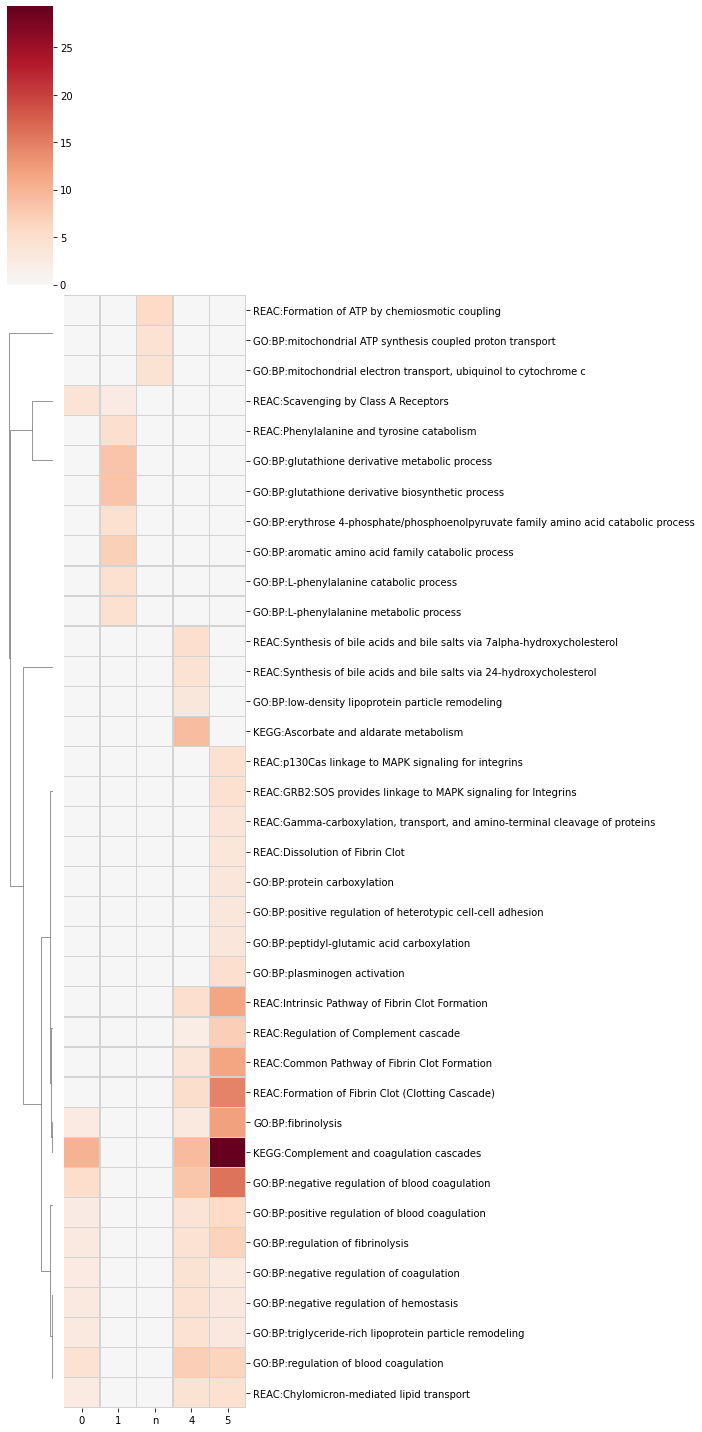

In [114]:
df_plot = pd.DataFrame()
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for group in dic_gs:
    temp_df = dic_pathway[group][['Adjusted P-value']]
    temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                     for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')

df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot.loc[df_plot.max(axis=1)>3]
# df_plot = df_plot[group_list]
df_plot.index.name = ''
df_plot.columns = [x[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, 
               figsize=(10,20), cbar_pos=(0, 0.9, 0.05, 0.05),
               cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

In [42]:
# # Pathway: enrichr
# dic_pathway = {}
# group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
# pw_list = []
# for group in group_list:
#     df_gene = sc.get.rank_genes_groups_df(adata, group=group)
#     gene_list = list(df_gene['names'][:100])

#     res = gp.enrichr(gene_list=gene_list, description='pathway',
#                          gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
#                          organism='Mouse', outdir=None)
#     df_pathway = res.results
#     df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
#     df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
#     df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
#     df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
#     dic_pathway[group] = df_pathway.copy()
#     ind_select = (df_pathway['Intersect']>50) | (df_pathway['Recall']>0.20)
# #     ind_select = (df_pathway['Intersect']>15) 
#     ind_select = ind_select & (df_pathway['Term_size']>10) & (df_pathway['Term_size']<500) 
#     pw_list.extend(df_pathway.loc[ind_select, 'Term'])

# for group in group_list:
# # for group in ['hq', 'lq']:
#     dic_pathway[group].index = dic_pathway[group]['Term']
#     dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

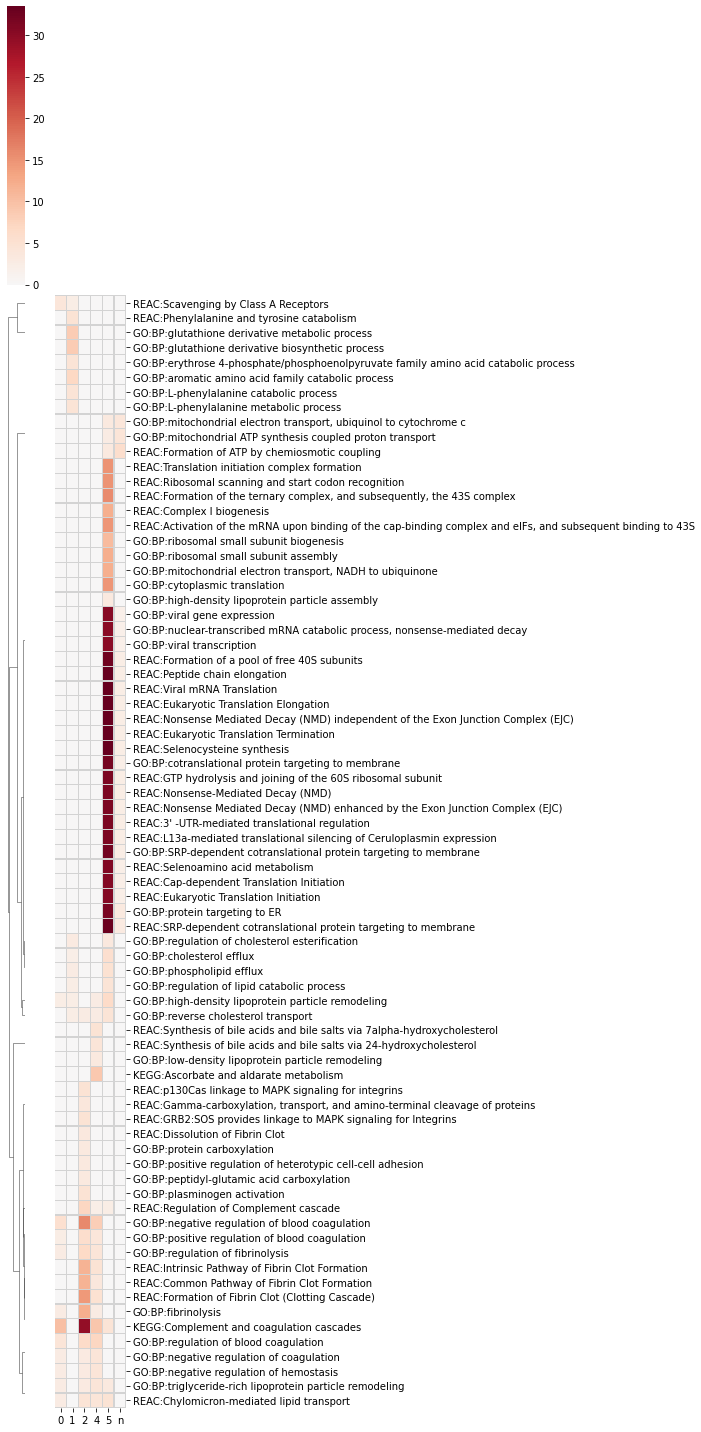

In [45]:
df_plot = pd.DataFrame()
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for group in group_list:
    temp_df = dic_pathway[group][['Adjusted P-value']]
    temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                     for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')

df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot.loc[df_plot.max(axis=1)>3]
df_plot = df_plot[group_list]
df_plot.index.name = ''
df_plot.columns = [x[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, 
               figsize=(10,20), cbar_pos=(0, 0.9, 0.05, 0.05),
               cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

### Joint regression analysis based on covariates 

In [265]:
# def qn(x):
#     v_rank = np.zeros(x.shape[0])
#     v_rank[np.argsort(x)] = np.arange(x.shape[0])
#     return v_rank/v_rank.shape[0]

# Get covariate profile 
dic_cov = {}

# FACS all 
dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
dic_cov['facs']['CV'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'CV.norm_score']
dic_cov['facs']['PN'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'PN.norm_score']

# aizarani
dic_cov['aizarani'] = dic_data_proc['aizarani'].obs.copy()
dic_cov['aizarani']['CV'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'CV.norm_score']
dic_cov['aizarani']['PN'] = dic_score['aizarani.hm'].loc[dic_cov['aizarani'].index, 'PN.norm_score']

# halpern
dic_cov['halpern'] = dic_data_proc['halpern'].obs.copy()
dic_cov['halpern']['CV'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'CV.norm_score']
dic_cov['halpern']['PN'] = dic_score['halpern.hm'].loc[dic_cov['halpern'].index, 'PN.norm_score']

In [266]:
# Check if the orignal DPT aligns with the CV/PN score
term = 'aizarani'
score = 'aizarani.hm'
cov = 'zonation'
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
for trait in ['CV', 'PN']:
    df_reg = dic_cov[term][[cov, 'n_genes']].copy()
    df_reg['const'] = 1
    df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
    df_reg = df_reg.join(dic_ctrl_score[score][trait])
    
    for col in df_reg:
        if 'score' in col:
            df_reg[col] = qn(df_reg[col])

    res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[['const', 'n_genes', cov]]).fit()
    t_ = res.tvalues[cov]
    v_t_ = np.zeros(500)
    for i in range(500):
        res = sm.OLS(df_reg['ctrl_norm_score_%d'%i],df_reg[['const', 'n_genes', cov]]).fit()
        v_t_[i] = res.tvalues[cov]
    p_ = ((t_ <= v_t_).sum()+1) / 501
    df_stats.loc['%s.%s'%(cov,trait), ['CORR', 'P']] = [t_, p_]
display(df_stats)

,COV,TRAIT,CORR,P
zonation.CV,NaN,NaN,-6.74181,0.886228
zonation.PN,NaN,NaN,6.66236,0.137725


In [246]:
# Compute p-value
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
dic_stats = {}
for term in dic_cov:
    df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
    ds = term.split('.')[0]
    score = term.split('.')[0]
    
    for cov in ['PN', 'CV']:
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                    
                df_stats.loc['%s.%s'%(cov,trait), ['COV', 'TRAIT']] = [cov, trait]
                
                df_reg = dic_cov[term][[cov, 'n_genes']].copy()
                df_reg['const'] = 1
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[['const', 'n_genes', cov]]).fit()
                t_ = res.tvalues[cov]
                v_t_ = np.zeros(500)
                for i in range(500):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i],df_reg[['const', 'n_genes', cov]]).fit()
                    v_t_[i] = res.tvalues[cov]
                p_ = ((t_ <= v_t_).sum()+1) / 501
                df_stats.loc['%s.%s'%(cov,trait), ['CORR', 'P']] = [t_, p_]
        
    df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
    df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]
    dic_stats[term] = df_stats

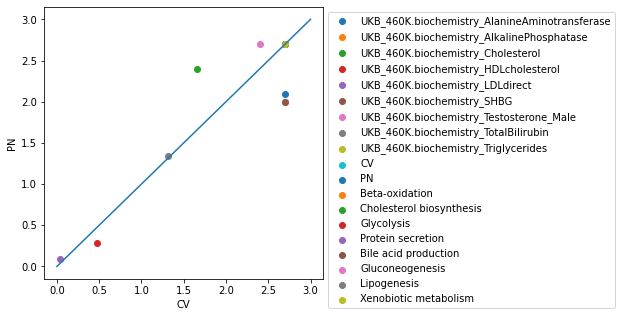

In [287]:
# Figure 
ds = 'facs'
for ds in ['aizarani']:
    df_plot = pd.DataFrame(index=DIC_TRAIT_LIST[ds]+DIC_TRAIT_LIST[ds+'.hm'], columns=['CV', 'PN'], dtype=float)
    for trait in df_plot.index:
        if 'CV.%s'%trait not in dic_stats[ds].index:
            continue
        df_plot.loc[trait] = [dic_stats[ds].loc['CV.%s'%trait, 'P'], dic_stats[ds].loc['PN.%s'%trait, 'P']]
    df_plot = -np.log10(df_plot)

    plt.figure(figsize=[5,5])
    for trait in df_plot.index:
        plt.scatter(df_plot.loc[trait, 'CV'], df_plot.loc[trait, 'PN'], label=trait)
    plt.plot([0,3],[0,3])
    plt.xlabel('CV')
    plt.ylabel('PN')
    plt.legend(loc='upper left', bbox_to_anchor=[1,1])
    plt.show()

In [288]:
df_plot

,CV,PN
UKB_460K.biochemistry_AlanineAminotransferase,2.699838,2.097778
UKB_460K.biochemistry_AlkalinePhosphatase,2.699838,2.699838
UKB_460K.biochemistry_Cholesterol,2.699838,2.699838
UKB_460K.biochemistry_HDLcholesterol,2.699838,2.699838
UKB_460K.biochemistry_LDLdirect,2.699838,2.699838
UKB_460K.biochemistry_SHBG,2.699838,2.699838
UKB_460K.biochemistry_Testosterone_Male,2.699838,2.699838
UKB_460K.biochemistry_TotalBilirubin,2.699838,2.699838
UKB_460K.biochemistry_Triglycerides,2.699838,2.699838
CV,2.699838,2.699838


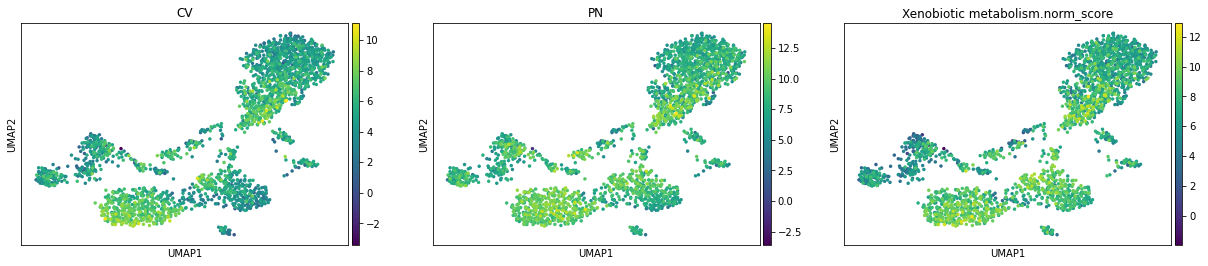

In [250]:
temp_data = dic_data_proc['aizarani'][dic_cov['aizarani'].index].copy()
temp_data.obs = temp_data.obs.join(dic_cov['aizarani'][['CV', 'PN']])
temp_data.obs = temp_data.obs.join(dic_score['aizarani.hm'])
sc.pl.umap(temp_data, color=['CV', 'PN', 'Xenobiotic metabolism.norm_score'])

In [154]:
sp.stats.spearmanr(temp_data.obs['zonation'], temp_data.obs['Bile acid production.norm_score'])

SpearmanrResult(correlation=-0.6235978413278115, pvalue=1.044857907490236e-37)

In [47]:
# Get data and zonation profile 
dic_data_zon = {}

# FACS hep data 
ds = 'facs'
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm
adata = adata[adata.obs['leiden'].isin(['2', '4'])].copy()
adata.obs['zonation'] = adata.obsm['X_umap'][:,0]
adata.obs['ctrl'] = adata[:,'Alb'].X.toarray().flatten()
adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
temp_dic = {0:-1, 1:-1, 2:0, 3:0, 4:1}
adata.obs['zonation_bin_o'] = [temp_dic[x] for x in adata.obs['zonation_bin']]
dic_data_zon['facs'] = adata.copy()

# aizarani hep data
ds = 'aizarani'
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
                      'Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t', index_col=1)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
adata.obs['cluster_id'] = adata.obs['cluster_id'].astype('category')
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obsm = temp_adata.obsm
adata.obs['n_genes'] = (adata.X>0).sum(axis=1)
# adata.obs = adata.obs.join(dic_score['aizarani'][['%s.fdr'%trait, '%s.norm_score'%trait]])
adata.obs['zonation'] = -1
# adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
temp_list = [x for x in temp_df.columns if x in adata.obs_names]
adata.obs.loc[temp_list, 'zonation'] = np.arange(len(temp_list))
adata = adata[adata.obs['zonation']>=0,:].copy()
adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
adata.obs['ctrl'] = adata[:,'ALB'].X.toarray().flatten()
adata = adata[adata.obs['n_genes']<=1500,:].copy()
# adata = adata[adata.obs['%s.fdr'%trait]<0.1].copy()
dic_data_zon['aizarani'] = adata.copy()

In [48]:
# Compute p-value
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'CORR', 'P'])


for dpt in ['zonation']:
    for ds in ['aizarani']:
        for trait in DIC_TRAIT_LIST['aizarani.hm']:
            df_plot = dic_data_zon[ds].obs[[dpt, 'ctrl']].copy()
            df_plot = df_plot.join(dic_score['aizarani.hm'].loc[dic_data_zon[ds].obs_names, ['%s.norm_score'%trait]])
            df_plot = df_plot.join(dic_ctrl_score['aizarani.hm'][trait])
            corr_ = sp.stats.pearsonr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
#             corr_ = sp.stats.spearmanr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
            v_corr_ = np.zeros(500)
            for i in range(500):
                v_corr_[i] = sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 v_corr_[i] = sp.stats.spearmanr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
            p_ = ((corr_ <= v_corr_).sum()+1) / 501
            df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

In [49]:
df_stats

,DPT,TRAIT,CORR,P,P_STR,P_STR_NUM
zonation.Beta-oxidation,zonation,Beta-oxidation,0.084765,0.227545,n.s.,P=0.228
zonation.Cholesterol biosynthesis,zonation,Cholesterol biosynthesis,0.029632,0.349301,n.s.,P=0.349
zonation.Glycolysis,zonation,Glycolysis,-0.143875,0.948104,n.s.,P=0.948
zonation.Protein secretion,zonation,Protein secretion,0.163892,0.029940,*,P=0.030
zonation.Bile acid production,zonation,Bile acid production,0.075667,0.191617,n.s.,P=0.192
zonation.Gluconeogenesis,zonation,Gluconeogenesis,-0.161923,0.916168,n.s.,P=0.916
zonation.Lipogenesis,zonation,Lipogenesis,-0.015325,0.562874,n.s.,P=0.563
zonation.Xenobiotic metabolism,zonation,Xenobiotic metabolism,0.322297,0.003992,***,P=0.004


In [81]:
sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl'].values)[0]

0.43842491823771557

In [91]:
from statsmodels.stats.multitest import multipletests

In [122]:
multipletests(v_p/5, method='fdr_bh')

(array([False,  True, False,  True,  True,  True, False,  True]),
 array([0.07904192, 0.04023952, 0.07436555, 0.04023952, 0.04023952,
        0.03832335, 0.05854957, 0.04023952]),
 0.006391150954545011,
 0.00625)

In [123]:
v_p/5

array([0.07904192, 0.01996008, 0.06506986, 0.01996008, 0.02195609,
       0.00479042, 0.04391218, 0.0251497 ])

In [117]:
v_p = np.array([min(x, 1-x) for x in df_stats['P']])

In [102]:
df_stats

,DPT,TRAIT,CORR,P,P_STR,P_STR_NUM
zonation_bin.Beta-oxidation,zonation_bin,Beta-oxidation,0.105355,0.395210,n.s.,P=0.395
zonation_bin.Cholesterol biosynthesis,zonation_bin,Cholesterol biosynthesis,-0.241579,0.900200,n.s.,P=0.900
zonation_bin.Glycolysis,zonation_bin,Glycolysis,0.095046,0.325349,n.s.,P=0.325
zonation_bin.Protein secretion,zonation_bin,Protein secretion,0.387076,0.099800,n.s.,P=0.100
zonation_bin.Bile acid production,zonation_bin,Bile acid production,-0.418860,0.890220,n.s.,P=0.890
zonation_bin.Gluconeogenesis,zonation_bin,Gluconeogenesis,0.516162,0.023952,*,P=0.024
zonation_bin.Lipogenesis,zonation_bin,Lipogenesis,0.167519,0.219561,n.s.,P=0.220
zonation_bin.Xenobiotic metabolism,zonation_bin,Xenobiotic metabolism,-0.450094,0.874251,n.s.,P=0.874


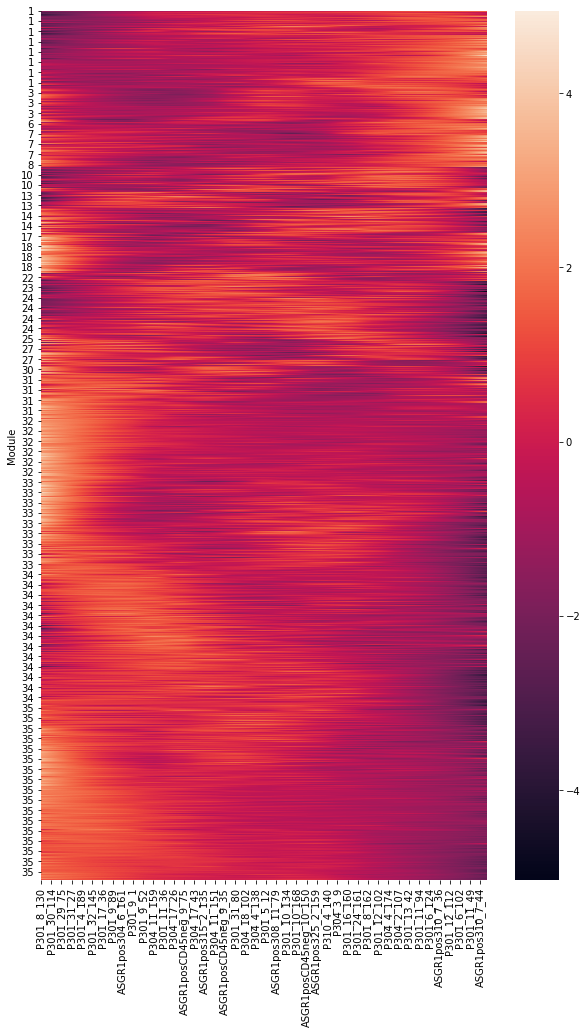

In [95]:
plt.figure(figsize=[10,16])
sns.heatmap(temp_df.iloc[:,1:])
plt.show()

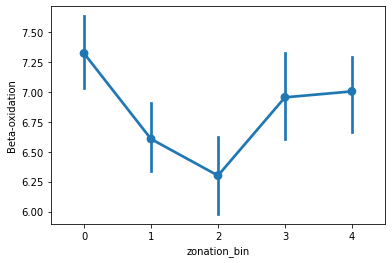

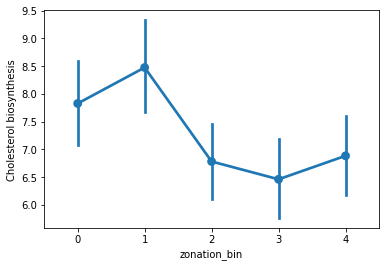

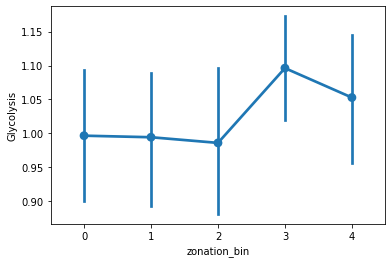

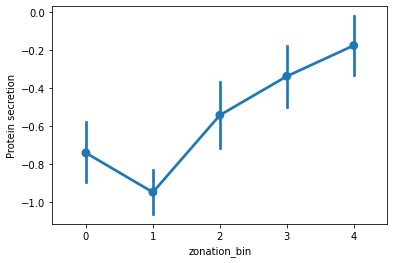

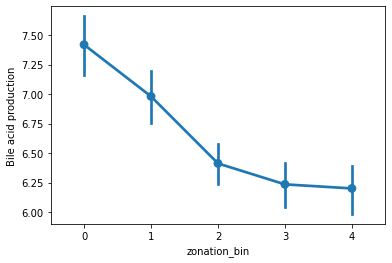

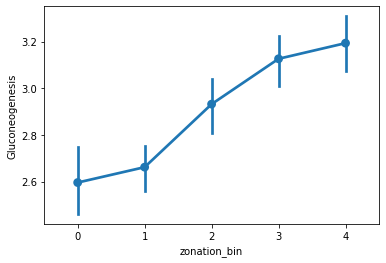

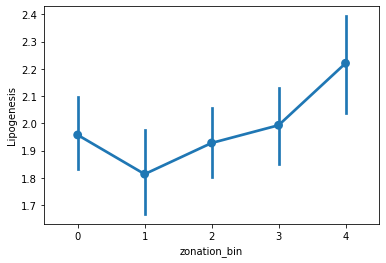

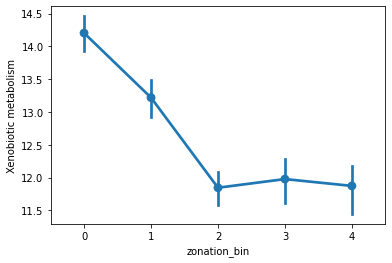

In [19]:
df = 'facs'
for trait in DIC_TRAIT_LIST['facs.hm']:
    
    df_plot = pd.DataFrame(data={'zonation': dic_data_zon[ds].obs['zonation'], 
                                 trait: dic_score['facs.hm'].loc[dic_data_zon[ds].obs_names, '%s.norm_score'%trait],
                                 'ctrl': dic_data_zon[ds].obs['ctrl']})
    df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
    plt.figure()
    sns.pointplot(data=df_plot, x='zonation_bin', y=trait)
    plt.show()

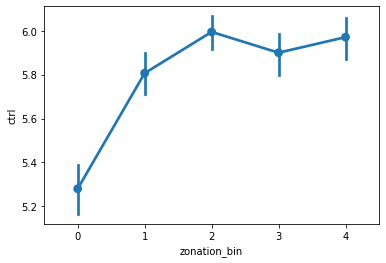

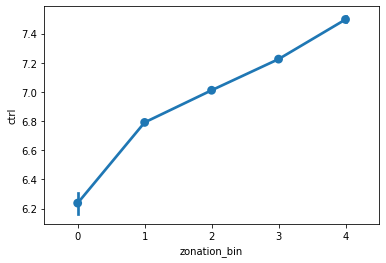

In [25]:
trait = 'UKB_460K.biochemistry_TotalBilirubin'
for ds in DS_LIST:
    
    df_plot = pd.DataFrame(data={'zonation': dic_data_zon[ds].obs['zonation'], 
                                 'score': dic_score[ds].loc[dic_data_zon[ds].obs_names, '%s.norm_score'%trait],
                                 'ctrl': dic_data_zon[ds].obs['ctrl']})
    df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
    plt.figure()
    sns.pointplot(data=df_plot, x='zonation_bin', y='ctrl')
    plt.show()

In [ ]:
sc.pl.umap(dic_data_zon['facs'], color=['%s.norm_score'%trait, 'zonation', 'n_genes', 'cluster_id'])

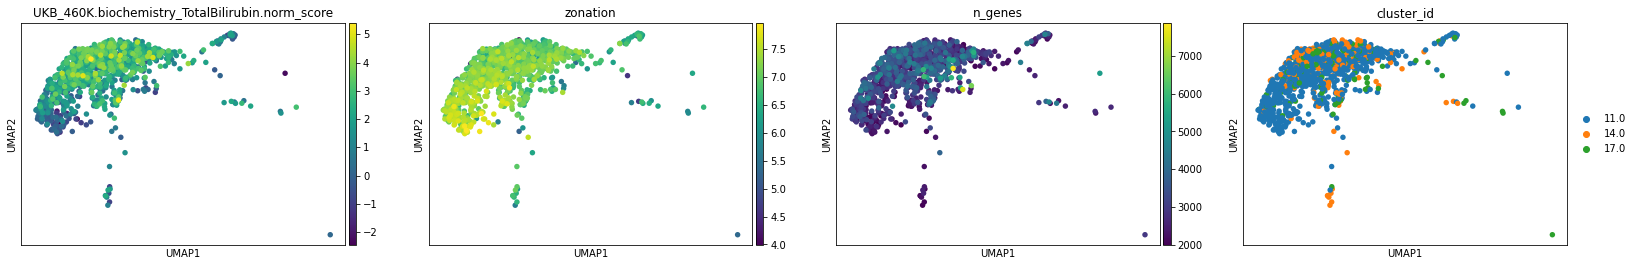

In [23]:
sc.pl.umap(dic_data_zon['aizarani'], color=['%s.norm_score'%trait, 'zonation', 'n_genes', 'cluster_id'])

In [122]:
dic_data_zon['aizarani'].obs['sig'] = dic_data_zon['aizarani'].obs['%s.fdr'%trait]<0.1
dic_data_zon['aizarani'].obs.groupby(['cluster_id', 'sig']).agg({'celltype':len})

celltype
cluster_id sig            
11.0       False       499
           True        228
14.0       False        85
           True         71
17.0       False        65
           True         55

In [117]:
temp_df

,GeneSymbol,P301_8_130,P301_8_127,P301_5_28,P301_4_98,P301_17_5,P301_10_123,P301_4_103,P301_8_131,P301_8_154,...,P301_6_175,P301_6_147,P301_18_146,P301_6_141,P301_6_153,P301_6_123,P301_6_181,P301_12_161,P301_6_178,P301_18_176
Module,,,,,,,,,,,,,,,,,,,,,
1,ACADM,-1.892985,-1.889814,-1.886645,-1.883479,-1.880315,-1.877153,-1.873993,-1.870836,-1.867681,...,-0.084579,-0.094507,-0.104455,-0.114421,-0.124406,-0.134410,-0.144433,-0.154474,-0.164533,-0.174611
1,AFM,-2.374369,-2.373595,-2.372819,-2.372039,-2.371257,-2.370472,-2.369684,-2.368893,-2.368099,...,0.565645,0.562683,0.559714,0.556738,0.553756,0.550767,0.547772,0.544771,0.541763,0.538749
1,AGL,-1.811760,-1.811965,-1.812166,-1.812363,-1.812555,-1.812744,-1.812929,-1.813109,-1.813285,...,2.140241,2.145407,2.150576,2.155749,2.160924,2.166102,2.171283,2.176467,2.181653,2.186842
1,ANTXR2,-1.799543,-1.797541,-1.795538,-1.793535,-1.791532,-1.789528,-1.787524,-1.785520,-1.783516,...,0.547106,0.546021,0.544938,0.543857,0.542777,0.541699,0.540624,0.539550,0.538479,0.537409
1,APLP2,-3.630012,-3.621315,-3.612630,-3.603959,-3.595299,-3.586652,-3.578018,-3.569395,-3.560785,...,0.962515,0.966911,0.971313,0.975720,0.980132,0.984550,0.988973,0.993401,0.997835,1.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,RPS19,1.950090,1.949356,1.948621,1.947886,1.947152,1.946417,1.945681,1.944946,1.944209,...,-2.185280,-2.188392,-2.191506,-2.194622,-2.197741,-2.200862,-2.203984,-2.207109,-2.210237,-2.213366
35,RPS9,1.899189,1.896911,1.894635,1.892362,1.890091,1.887822,1.885555,1.883291,1.881028,...,-2.033410,-2.034628,-2.035842,-2.037053,-2.038260,-2.039464,-2.040665,-2.041862,-2.043056,-2.044246
35,SEC14L2,2.087039,2.084403,2.081768,2.079134,2.076500,2.073868,2.071236,2.068605,2.065975,...,-1.725249,-1.725800,-1.726347,-1.726892,-1.727434,-1.727972,-1.728507,-1.729040,-1.729569,-1.730095


In [56]:
trait = 'UKB_460K.biochemistry_LDLdirect'

In [46]:
dic_data_zon['aizarani'].obs.loc['P301_8_130']

cluster_id             14
cell_id        P301_8_130
celltype      hepatocytes
n_counts          11997.8
zonation                0
Name: P301_8_130, dtype: object

In [35]:
set(temp_df.columns) - set(adata.obs_names)

{'GeneSymbol'}

In [36]:
temp_df.shape

(3395, 2535)

In [32]:
[x for x in temp_df.columns if x[0]!='P']

['GeneSymbol',
 'ASGR1pos310_6_158',
 'ASGR1pos310_6_146',
 'ASGR1pos310_5_21',
 'ASGR1pos310_5_15',
 'ASGR1pos315_1_39',
 'ASGR1pos310_8_135',
 'ASGR1pos308_11_57',
 'ASGR1pos310_5_36',
 'ASGR1pos325_1_21',
 'ASGR1pos310_5_85',
 'ASGR1pos325_1_66',
 'LSEC325_14_168',
 'ASGR1pos310_6_149',
 'ASGR1pos308_9_93',
 'ASGR1pos304_7_32',
 'ASGR1pos308_10_130',
 'Mixed315_11_57',
 'ASGR1pos308_10_169',
 'ASGR1pos304_7_93',
 'ASGR1pos304_7_24',
 'ASGR1pos308_10_122',
 'ASGR1pos308_9_41',
 'ASGR1pos304_7_30',
 'ASGR1pos325_1_43',
 'ASGR1pos315_3_48',
 'ASGR1pos304_8_146',
 'ASGR1pos304_5_11',
 'ASGR1pos304_7_53',
 'ASGR1pos304_8_103',
 'ASGR1pos304_5_7',
 'Mixed315_12_155',
 'ASGR1pos310_5_20',
 'ASGR1pos304_6_106',
 'ASGR1pos304_5_56',
 'ASGR1pos308_9_81',
 'ASGR1pos315_2_129',
 'ASGR1pos304_6_143',
 'ASGR1pos304_8_127',
 'ASGR1pos304_7_78',
 'ASGR1pos304_6_127',
 'ASGR1pos315_3_92',
 'ASGR1pos308_10_146',
 'ASGR1pos308_12_142',
 'ASGR1pos304_8_129',
 'ASGR1pos315_3_6',
 'ASGR1posCD45neg_9_68',

In [ ]:
df_plot = pd.DataFrame(data={'zonation':adata_sub.obsm['X_umap'][:,0].flatten(), 
                             'score': adata_sub.obs['%s.norm_score'%trait]})
df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
sns.pointplot(data=df_plot, x='zonation_bin', y='score')
# plt.scatter(adata_sub.obsm['X_umap'][:,0].flatten(), adata_sub.obs['%s.norm_score'%trait])

In [ ]:
# # FACS all 
# dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
# dic_cov['facs']['CV'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'CV.norm_score']
# dic_cov['facs']['PN'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'PN.norm_score']
# # dic_cov['facs']['zonation'] = dic_cov['facs']['PN'] - dic_cov['facs']['CV']
# # dic_cov['facs']['zonation'] = (dic_cov['facs']['zonation']-dic_cov['facs']['zonation'].mean())\
# #                                 /dic_cov['facs']['zonation'].std()

### Prioritize gene sets 

In [52]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [54]:
# Hep specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['hep'] = 'nh'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'hep'] = 'h'
sc.tl.rank_genes_groups(temp_adata, groupby='hep', groups=['h'])
df_h = sc.get.rank_genes_groups_df(temp_adata, 'h')

... storing 'tissue_celltype' as categorical
... storing 'hep' as categorical


In [87]:
# GWAS and scTRS gene sets 
dic_gs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
#     temp_list = dic_data_proc['facs'].obs_names[dic_data_proc['facs'].obs['leiden'].isin(['2'])]
#     temp_adata = dic_data_raw['facs'][temp_list, list(background_set)].copy()
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    
    # tcell-specific genes 
    dic_gs['%s.hep'%trait] = set(df_h['names'][:len(dic_gs['%s.gwas'%trait])])

In [88]:
# Gold standard gene sets 
dic_ref = {'UKB_460K.biochemistry_TotalBilirubin': 'Forgetta_biorxiv_2020:dbilirubin.med',
           'UKB_460K.biochemistry_LDLdirect': 'Forgetta_biorxiv_2020:ldl.med;Forgetta_biorxiv_2020:ldl.drug',
           'UKB_460K.biochemistry_Triglycerides': 'Forgetta_biorxiv_2020:tg.med;Forgetta_biorxiv_2020:tg.drug',
           'UKB_460K.biochemistry_Cholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease',
           'UKB_460K.biochemistry_HDLcholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease'}
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Freund_AJHG_2018', 'Forgetta_biorxiv_2020']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
#     break
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [89]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'hep']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

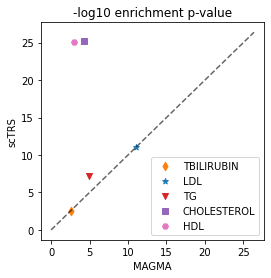

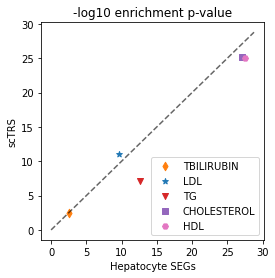

In [92]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scTRS'], 
              'hep': ['C2', 'Hepatocyte SEGs']}

dic_config_trait = {'UKB_460K.biochemistry_TotalBilirubin': ['C1', 'd'], 
                    'UKB_460K.biochemistry_LDLdirect': ['C0', '*'], 
                    'UKB_460K.biochemistry_Triglycerides': ['C3', 'v'], 
                    'UKB_460K.biochemistry_Cholesterol': ['C4', 's'],
                    'UKB_460K.biochemistry_HDLcholesterol': ['C6', 'H'],
#                     'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats[res][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'hep']:
    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2)
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], marker=dic_config_trait[trait][1], 
                    label=DF_TRAIT_INFO.loc[trait, 'Code'])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.6)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.title('-log10 enrichment p-value')
    plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()

### Old code

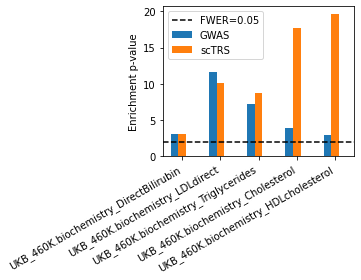

In [109]:
dic_config = {'gwas': ['C0', 'GWAS'], 
              'sctrs': ['C1', 'scTRS']}

df_plot = dic_stats[res][['GS']].copy()
for res in ['gwas', 'sctrs']:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
#     df_plot['%s.or'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio']
#     df_plot['%s.or_lb'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.lb']
#     df_plot['%s.or_ub'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.ub']
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])


plt.figure(figsize=[5, 4])
for i_res,res in enumerate(['gwas', 'sctrs']):
    mat_xerr = np
    plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
            width=0.2, color=dic_config[res][0], label=dic_config[res][1])

fwer_thres = -np.log10(0.05/df_plot.shape[0])
plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
         label='FWER=0.05')

plt.legend()
plt.xticks(df_plot['loc'], [x for x in df_plot.index], rotation=30, ha='right')
plt.ylabel('Enrichment p-value')
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs.svg')
plt.show()

In [ ]:
# Compute p-value
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
dic_stats = {}
for term in dic_cov:
    df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
    ds = term.split('.')[0]
    score = term.split('.')[0]
    
    for cov in ['PN', 'CV']:
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                    
                df_stats.loc['%s.%s'%(cov,trait), ['COV', 'TRAIT']] = [cov, trait]
                
                df_reg = dic_cov[term][[cov, 'n_genes']].copy()
                df_reg['const'] = 1
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
#                 res = sm.OLS(df_reg[cov], df_reg[['const', 'n_genes', '%s.norm_score'%trait]]).fit()
#                 t_ = res.tvalues['%s.norm_score'%trait]
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[['const', 'n_genes', cov]]).fit()
                t_ = res.tvalues[cov]
                v_t_ = np.zeros(500)
                for i in range(500):
#                     res = sm.OLS(df_reg[cov],df_reg[['const', 'n_genes', 'ctrl_norm_score_%d'%i]]).fit()
#                     v_t_[i] = res.tvalues['ctrl_norm_score_%d'%i]
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i],df_reg[['const', 'n_genes', cov]]).fit()
                    v_t_[i] = res.tvalues[cov]
                p_ = ((t_ <= v_t_).sum()+1) / 501
                df_stats.loc['%s.%s'%(cov,trait), ['CORR', 'P']] = [t_, p_]
            
#                 df_plot = dic_cov[term][[cov]].copy()
#                 df_plot = df_plot.join(dic_score[score][['%s.norm_score'%trait]])
#                 df_plot = df_plot.join(dic_ctrl_score[score][trait])
#         #         corr_ = sp.stats.pearsonr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
#                 corr_ = sp.stats.spearmanr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
#                 v_corr_ = np.zeros(500)
#                 for i in range(500):
#         #             v_corr_[i] = sp.stats.pearsonr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                     v_corr_[i] = sp.stats.spearmanr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 p_ = ((corr_ <= v_corr_).sum()+1) / 501
#                 df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]
        
    df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
    df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]
    dic_stats[term] = df_stats